In [ ]:
!pip install nltk

In [ ]:
#Importing the necessary packages
import requests
from bs4 import BeautifulSoup
from nltk.sentiment import SentimentAnalyzer
import nltk.sentiment.util
from nltk.classify import NaiveBayesClassifier
from collections import defaultdict
import random
import json
import os
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import string
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
#Yelp API token
YELP_TOKEN = '4Qyk1hzW-_PwVKzMoq0I2s-rrLlbuZGVZ93m3k2e2_X4lftkdvDNieK8l45ilYEyykviIZef1s3l4cnx075ttQkSR75db1mGdd2BGuJsoRPUhNMhL3J9KT9XIBWcZXYx'
#API endpoint URL for Yelp's business search
url = 'https://api.yelp.com/v3/businesses/search'
#Headers including the authorization token
headers = {'Authorization': f'Bearer {YELP_TOKEN}'}
#Parameters for API request
params = {'location': 'Toronto','limit': 50,'offset':0}
all_businesses = []
business_urls=[]
#Loop to fetch data from multiple pages
for i in range(5):
    #Making the API request
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    #Extracting businesses information
    bss = data.get('businesses', [])
    #Storing business data
    all_businesses.extend(bss)
    #Extracting and storing business URLs
    business_urls.extend([j['url'] for j in bss])
    #Updating the offset for next batch of results
    params['offset'] += params['limit']

In [ ]:
#Business data output
all_businesses[:10]

[{'id': 'r_BrIgzYcwo1NAuG9dLbpg',
  'alias': 'pai-northern-thai-kitchen-toronto-5',
  'name': 'Pai Northern Thai Kitchen',
  'image_url': 'https://s3-media4.fl.yelpcdn.com/bphoto/uAnTcmLEQJWkCUOtvZMALA/o.jpg',
  'is_closed': False,
  'url': 'https://www.yelp.com/biz/pai-northern-thai-kitchen-toronto-5?adjust_creative=0b8PGFV1O0hANiqeXTulvw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=0b8PGFV1O0hANiqeXTulvw',
  'review_count': 3565,
  'categories': [{'alias': 'thai', 'title': 'Thai'}],
  'rating': 4.5,
  'coordinates': {'latitude': 43.64784, 'longitude': -79.38872},
  'transactions': [],
  'price': '$$',
  'location': {'address1': '18 Duncan Street',
   'address2': '',
   'address3': '',
   'city': 'Toronto',
   'zip_code': 'M5H 3G8',
   'country': 'CA',
   'state': 'ON',
   'display_address': ['18 Duncan Street', 'Toronto, ON M5H 3G8', 'Canada']},
  'phone': '+14169014724',
  'display_phone': '+1 416-901-4724',
  'distance': 3009.3347434869856},
 {'id': 'mZRKH9

In [ ]:
#Business URL output
business_urls[:10]

['https://www.yelp.com/biz/pai-northern-thai-kitchen-toronto-5?adjust_creative=0b8PGFV1O0hANiqeXTulvw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=0b8PGFV1O0hANiqeXTulvw',
 'https://www.yelp.com/biz/richmond-station-toronto?adjust_creative=0b8PGFV1O0hANiqeXTulvw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=0b8PGFV1O0hANiqeXTulvw',
 'https://www.yelp.com/biz/osteria-giulia-toronto?adjust_creative=0b8PGFV1O0hANiqeXTulvw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=0b8PGFV1O0hANiqeXTulvw',
 'https://www.yelp.com/biz/byblos-toronto-2?adjust_creative=0b8PGFV1O0hANiqeXTulvw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=0b8PGFV1O0hANiqeXTulvw',
 'https://www.yelp.com/biz/ristorante-sotto-sotto-toronto?adjust_creative=0b8PGFV1O0hANiqeXTulvw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=0b8PGFV1O0hANiqeXTulvw',
 'https://www.yelp.com/biz/lee-toronto-6?adjust_creative=0b8PGF

In [ ]:
#Dictionary to store the initial reviews for each business
initial_reviews = {}
headers = {"Authorization": "Bearer %s" % YELP_TOKEN}
#Loop through each business url
for url in business_urls:
    response = requests.get(url, headers=headers)
    #Parsing HTML content of the Yelp page
    soup = BeautifulSoup(response.content, 'html.parser')
    lst = []
    #Find all span elements with a specific class containing the review text
    review_spanning = soup.find_all('span', class_='raw__09f24__T4Ezm')
    #Iterate through each span element and extract review text
    for span in review_spanning:
        review_txt = span.get_text(separator=" ", strip=True)
        lst.append(review_txt)
    #Store list of reviews for the url in the dictionary created
    initial_reviews[url] = lst

## Cleaning the Reviews Data

In [ ]:
#Converting the reviews data from a dictionary to a list
all_reviews = []
for reviews in initial_reviews.values():
    all_reviews.extend(reviews)
all_reviews[:10]

['18 Duncan Street',
 'Toronto, ON M5H 3G8',
 'Canada',
 '0.2 miles away from Pai Northern Thai Kitchen',
 'Start your review of Pai Northern Thai Kitchen',
 "My friend and I wanted to catch up over dinner on a Saturday evening, and she picked this place (as she read great reviews). We didn't have a reservation, so we waited in line and the friendly staff at the front took down one of our names. Then we were informed that it would be about 30 minute wait and were asked to wait until our name was called. While waiting, we looked around- the vibe was energetic and fun, the customers were eating and laughing. The decor was cool- the lights were dimmed, there were various colourful objects all around to evoke a comfy feel. I thought the place was pretty small, until our name was called and we were led to a table by a friendly young lady. The place was huge- there were multiple sections and each section had its own decor! Our seat was at the end section, where the decor reminded us of sitti

In [ ]:
#Function used to remove the strings containing only distance information and the prequel to the actual review
def clean_review_text(review):
    review = re.sub(r'\d+(\.\d+)? miles away from [^\n]+', '', review)
    review = re.sub(r'Start your review of [^\n]+', '', review)
    return review.strip()
#Produce the cleaned review data
cleaned_reviews = [clean_review_text(review) for review in all_reviews]
cleaned_reviews[:10]

['18 Duncan Street',
 'Toronto, ON M5H 3G8',
 'Canada',
 '',
 '',
 "My friend and I wanted to catch up over dinner on a Saturday evening, and she picked this place (as she read great reviews). We didn't have a reservation, so we waited in line and the friendly staff at the front took down one of our names. Then we were informed that it would be about 30 minute wait and were asked to wait until our name was called. While waiting, we looked around- the vibe was energetic and fun, the customers were eating and laughing. The decor was cool- the lights were dimmed, there were various colourful objects all around to evoke a comfy feel. I thought the place was pretty small, until our name was called and we were led to a table by a friendly young lady. The place was huge- there were multiple sections and each section had its own decor! Our seat was at the end section, where the decor reminded us of sitting inside someone's home. Our server was a second friendly young lady. She warmly greeted u

In [ ]:
#Replace the strings containing only Canada with an empty string
cleaned_reviews1 = [review.replace('Canada', '') for review in cleaned_reviews]

In [ ]:
cleaned_reviews1

['18 Duncan Street',
 'Toronto, ON M5H 3G8',
 '',
 '',
 '',
 "My friend and I wanted to catch up over dinner on a Saturday evening, and she picked this place (as she read great reviews). We didn't have a reservation, so we waited in line and the friendly staff at the front took down one of our names. Then we were informed that it would be about 30 minute wait and were asked to wait until our name was called. While waiting, we looked around- the vibe was energetic and fun, the customers were eating and laughing. The decor was cool- the lights were dimmed, there were various colourful objects all around to evoke a comfy feel. I thought the place was pretty small, until our name was called and we were led to a table by a friendly young lady. The place was huge- there were multiple sections and each section had its own decor! Our seat was at the end section, where the decor reminded us of sitting inside someone's home. Our server was a second friendly young lady. She warmly greeted us and 

In [ ]:
#Function used to remove those strings containing the address and postal code only
def remove_toronto_strings(review):
    pattern = re.compile(r'\b.*Toronto.*\b')
    return pattern.sub('', review)
#Produce the cleaned review data
cleaned_reviews2 = [remove_toronto_strings(review) for review in cleaned_reviews1]

In [ ]:
cleaned_reviews2

['18 Duncan Street',
 '',
 '',
 '',
 '',
 "My friend and I wanted to catch up over dinner on a Saturday evening, and she picked this place (as she read great reviews). We didn't have a reservation, so we waited in line and the friendly staff at the front took down one of our names. Then we were informed that it would be about 30 minute wait and were asked to wait until our name was called. While waiting, we looked around- the vibe was energetic and fun, the customers were eating and laughing. The decor was cool- the lights were dimmed, there were various colourful objects all around to evoke a comfy feel. I thought the place was pretty small, until our name was called and we were led to a table by a friendly young lady. The place was huge- there were multiple sections and each section had its own decor! Our seat was at the end section, where the decor reminded us of sitting inside someone's home. Our server was a second friendly young lady. She warmly greeted us and showed us the menu 

In [ ]:
#Function used to remove those strings which are addresses of the businesses only
def remove_addresses(review):
    address_pattern = re.compile(r'\b\d+\s+\w+(\s\w+)*\b')
    return address_pattern.sub('', review)
#Produce the cleaned review data
reviews_without_addresses = [remove_addresses(review) for review in cleaned_reviews2]

In [ ]:
#Remove those strings which are empty from the review data
cleaned_reviews3 = [review for review in reviews_without_addresses if review.strip()]
cleaned_reviews3[:10]

["My friend and I wanted to catch up over dinner on a Saturday evening, and she picked this place (as she read great reviews). We didn't have a reservation, so we waited in line and the friendly staff at the front took down one of our names. Then we were informed that it would be about . While waiting, we looked around- the vibe was energetic and fun, the customers were eating and laughing. The decor was cool- the lights were dimmed, there were various colourful objects all around to evoke a comfy feel. I thought the place was pretty small, until our name was called and we were led to a table by a friendly young lady. The place was huge- there were multiple sections and each section had its own decor! Our seat was at the end section, where the decor reminded us of sitting inside someone's home. Our server was a second friendly young lady. She warmly greeted us and showed us the menu (QR code). She said she'll be back to take our order in a few minutes. To start, we ordered Shrimp Chips

In [ ]:
#Function used to remove those strings which are only punctuations
def is_only_punctuation(s):
    s_clean = s.translate(str.maketrans('', '', string.punctuation))
    return not s_clean.strip()
#Produce the final review data to be used for sentiment analysis
filtered_reviews = [review for review in cleaned_reviews3 if not is_only_punctuation(review)]
filtered_reviews[:10]

["My friend and I wanted to catch up over dinner on a Saturday evening, and she picked this place (as she read great reviews). We didn't have a reservation, so we waited in line and the friendly staff at the front took down one of our names. Then we were informed that it would be about . While waiting, we looked around- the vibe was energetic and fun, the customers were eating and laughing. The decor was cool- the lights were dimmed, there were various colourful objects all around to evoke a comfy feel. I thought the place was pretty small, until our name was called and we were led to a table by a friendly young lady. The place was huge- there were multiple sections and each section had its own decor! Our seat was at the end section, where the decor reminded us of sitting inside someone's home. Our server was a second friendly young lady. She warmly greeted us and showed us the menu (QR code). She said she'll be back to take our order in a few minutes. To start, we ordered Shrimp Chips

## Sentiment Analysis of Reviews

In [ ]:
#Conducting Sentiment Analysis with VADER to determine if the reviews are positive or negative
nltk.download('vader_lexicon')
def determine_sentiment_vader(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    if sentiment_scores['compound'] >= 0.5:
        return 'positive'
    else:
        return 'negative'
#Labeling the sentiment onto the review
labeled_reviews = [(review, determine_sentiment_vader(review)) for review in filtered_reviews]
labeled_reviews[:10]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


[("My friend and I wanted to catch up over dinner on a Saturday evening, and she picked this place (as she read great reviews). We didn't have a reservation, so we waited in line and the friendly staff at the front took down one of our names. Then we were informed that it would be about . While waiting, we looked around- the vibe was energetic and fun, the customers were eating and laughing. The decor was cool- the lights were dimmed, there were various colourful objects all around to evoke a comfy feel. I thought the place was pretty small, until our name was called and we were led to a table by a friendly young lady. The place was huge- there were multiple sections and each section had its own decor! Our seat was at the end section, where the decor reminded us of sitting inside someone's home. Our server was a second friendly young lady. She warmly greeted us and showed us the menu (QR code). She said she'll be back to take our order in a few minutes. To start, we ordered Shrimp Chip

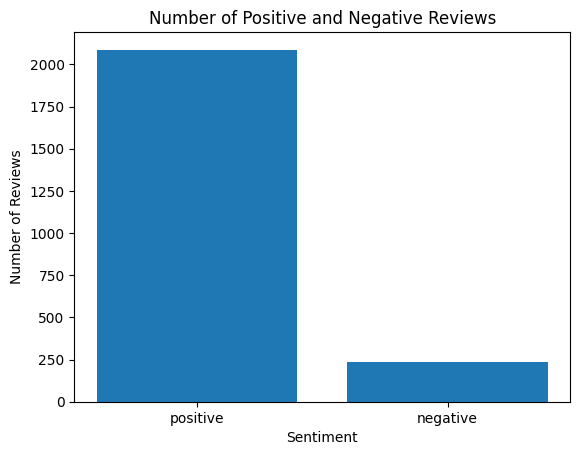

In [ ]:
#Counting the number of positive and negative reviews found in the reviews data
sentiments = [sentiment for _, sentiment in labeled_reviews]
sentiment_counts = Counter(sentiments)
labels = sentiment_counts.keys()
counts = sentiment_counts.values()
#Create a barplot of frequency of positive and negative reviews in the data
plt.bar(labels, counts)
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Number of Positive and Negative Reviews')
plt.show()

In [ ]:
#Finding the positive and negative words in the reviews
sid = SentimentIntensityAnalyzer()
vader_lexicon = sid.lexicon
positive_words = []
negative_words = []
for review in filtered_reviews:
    for word in review.split():
        if word.lower() in vader_lexicon:
            if vader_lexicon[word.lower()] > 0.1:
                positive_words.append(word)
            elif vader_lexicon[word.lower()] < -0.1:
                negative_words.append(word)

In [ ]:
#The positive words in the reviews
positive_words

['friend',
 'great',
 'friendly',
 'energetic',
 'pretty',
 'friendly',
 'friendly',
 'warmly',
 'greeted',
 'friend',
 'like',
 'friend',
 'enjoyed',
 'liked',
 'sure',
 'generous',
 'excellent',
 'excellent',
 'good',
 'good',
 'Excellent',
 'friend',
 'loves',
 'ok',
 'chance',
 'ok',
 'like',
 'warmers',
 'positive',
 'welcome',
 'chance',
 'giving',
 'exciting',
 'Highlight',
 'Loved',
 'Great',
 'great',
 'impressive',
 'great',
 'generous',
 'rich',
 'perfectly',
 'Sweet',
 'fresh',
 'Grand',
 'fresh',
 'good',
 'nice',
 'perfect',
 'well',
 'party',
 'good',
 'best',
 'recommend',
 'definitely',
 'best',
 'favorite',
 'well',
 'positive',
 'shared',
 'good',
 'liked',
 'recommend',
 'recommend',
 'wish',
 'like',
 'curious',
 'loved',
 'Slaw',
 'loved',
 'sweetness',
 'good',
 'perfect',
 'harmonious',
 'truly',
 'appreciate',
 'well',
 'enjoyment',
 'Worth',
 'definitely',
 'worth',
 'Yes',
 'Great',
 'definitely',
 'sweet',
 'loved',
 'enjoyable',
 'like',
 'worth',
 'friendl

In [ ]:
#The negative words in the reviews
negative_words

['Shame',
 'no',
 'uncomfortable',
 'no',
 'No',
 'limited',
 'complain',
 'unsure',
 'hard',
 'leave',
 'no',
 'pain',
 'poor',
 'cut',
 'hesitant',
 'Unfortunate',
 'disappointed',
 'sick',
 'wrong',
 'tough',
 'die',
 'No',
 'hard',
 'no',
 'snafu',
 'trouble',
 'worse',
 'Dumplings',
 'cut',
 'wrong',
 'cut',
 'cut',
 'no',
 'bad',
 'disappointing',
 'cut',
 'disappointing',
 'embarrassed',
 'worst',
 'suspect',
 'annoyed',
 'suckered',
 'die',
 'tenderloin',
 'weakest',
 'cut',
 'wrong',
 'trouble',
 'uncomfortable',
 'moody',
 'disappointed',
 'lack',
 'unprofessional',
 'no',
 'terrible',
 'flustered',
 'no',
 'disappointed',
 'dumplings',
 'Dumplings',
 'hard',
 'disappointed',
 'sorry',
 'stuck',
 'hesitant',
 'sorry',
 'bomb',
 'disappointing',
 'inconvenience',
 'allergic',
 'dumplings',
 'sorry',
 'wrong',
 'terrible',
 'gross',
 'sorry',
 'severely',
 'bad',
 'severely',
 'pay',
 'no',
 'tired',
 'pay',
 'no',
 'aggressive',
 'no',
 'crazy',
 'cuts',
 'bad',
 'lack',
 'Ser

In [ ]:
#Converting the review data into lists of reviews and labels
reviews, labels = zip(*labeled_reviews)
#Convert reviews into a matrix of token counts
vectorizer = CountVectorizer()
#Transform the reviews into a sparse matrix of token counts
features = vectorizer.fit_transform(reviews)

In [ ]:
#Divide the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

In [ ]:
#Initialize Multinomial Naive Bayes Classifier
clf = MultinomialNB()
#Train the classifier
clf.fit(X_train, y_train)

MultinomialNB()

In [ ]:
#Get the predictions of labels and the f1-score of the review data
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9096774193548387
              precision    recall  f1-score   support

    negative       1.00      0.16      0.28        50
    positive       0.91      1.00      0.95       415

    accuracy                           0.91       465
   macro avg       0.95      0.58      0.61       465
weighted avg       0.92      0.91      0.88       465



## Converting Reviews Data with Sentiments to a JSON file

In [ ]:
import pandas as pd
#Convert the labeled reviews data with sentiment into a dataframe
df_reviews=pd.DataFrame(labeled_reviews, columns=['Review Text','Sentiment'])
#Generate a json file of the reviews data
df_reviews.to_json('data.json', orient='records', lines=True)